<center>

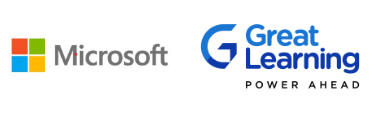
</center>

#**Information Retrieval tasks with Generative AI - Hands on Handbook**

##**Index:**

1. Setup

2. Assemble Vector Database

3. Querying the Vector Database

4. Evaluate Results

<p align="right">
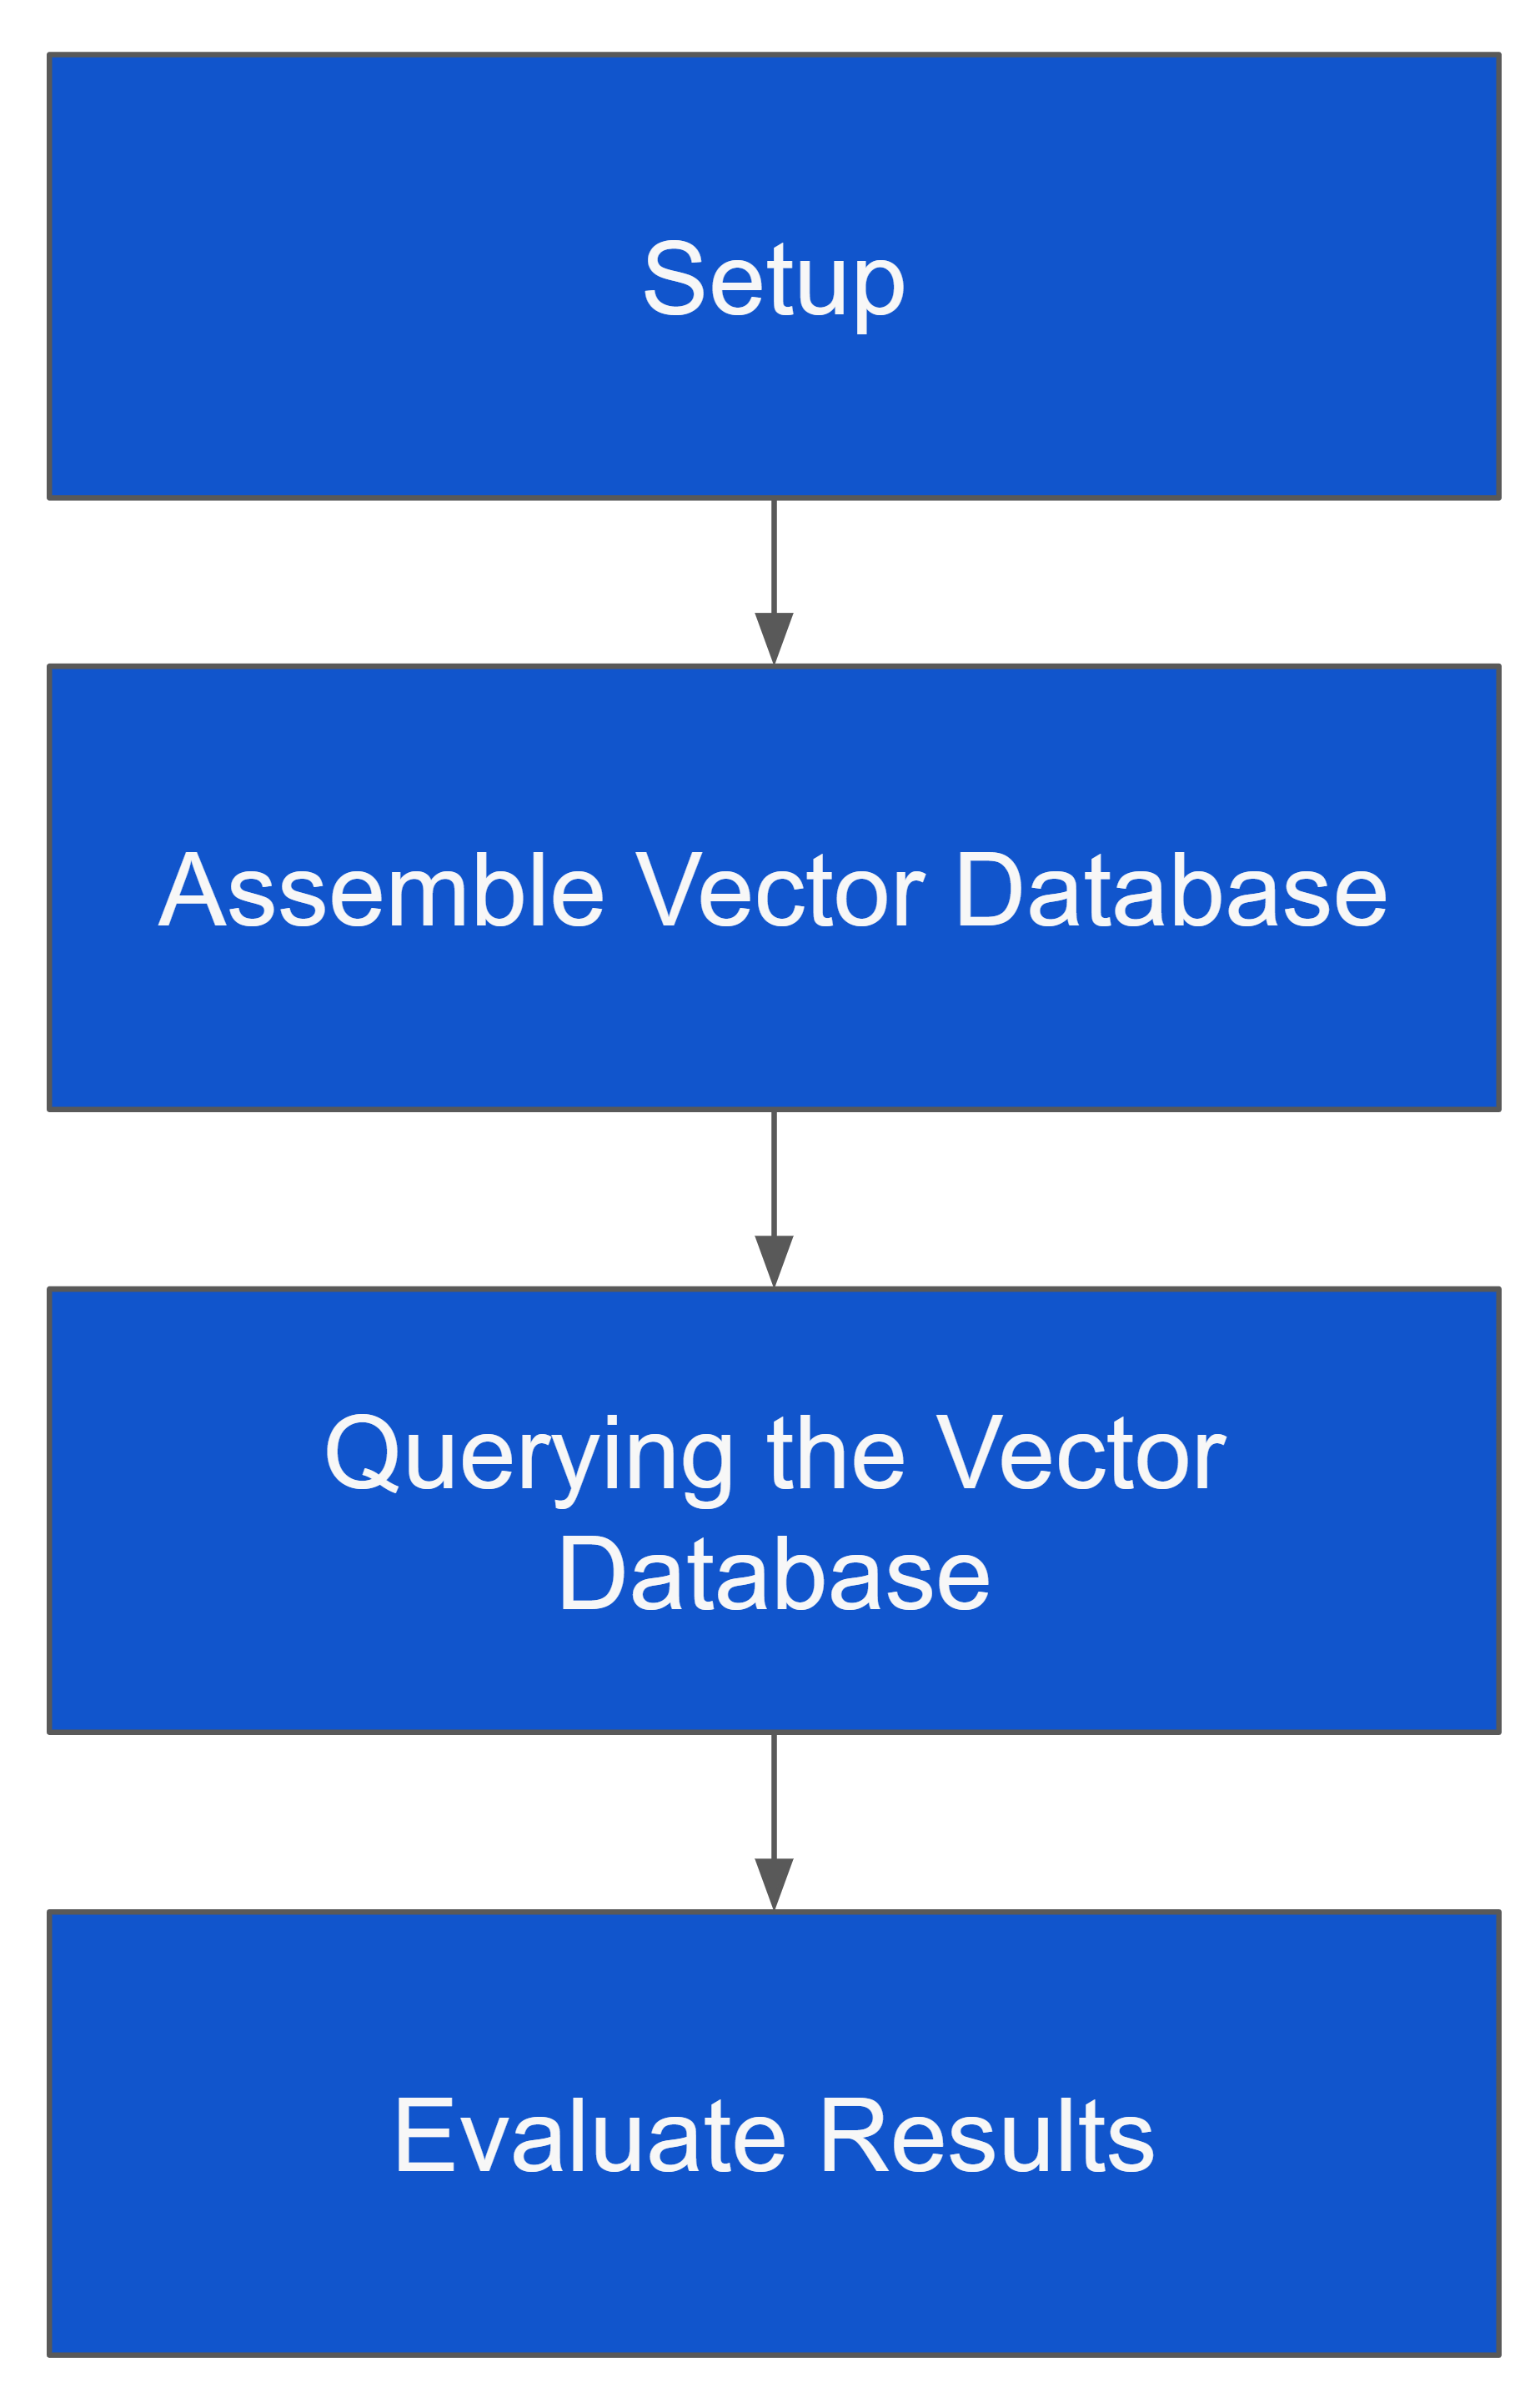
</p>

## **1. Setup**

###**Steps:**

1.1 Installation and Import

1.2 Authentication

<p align="right">
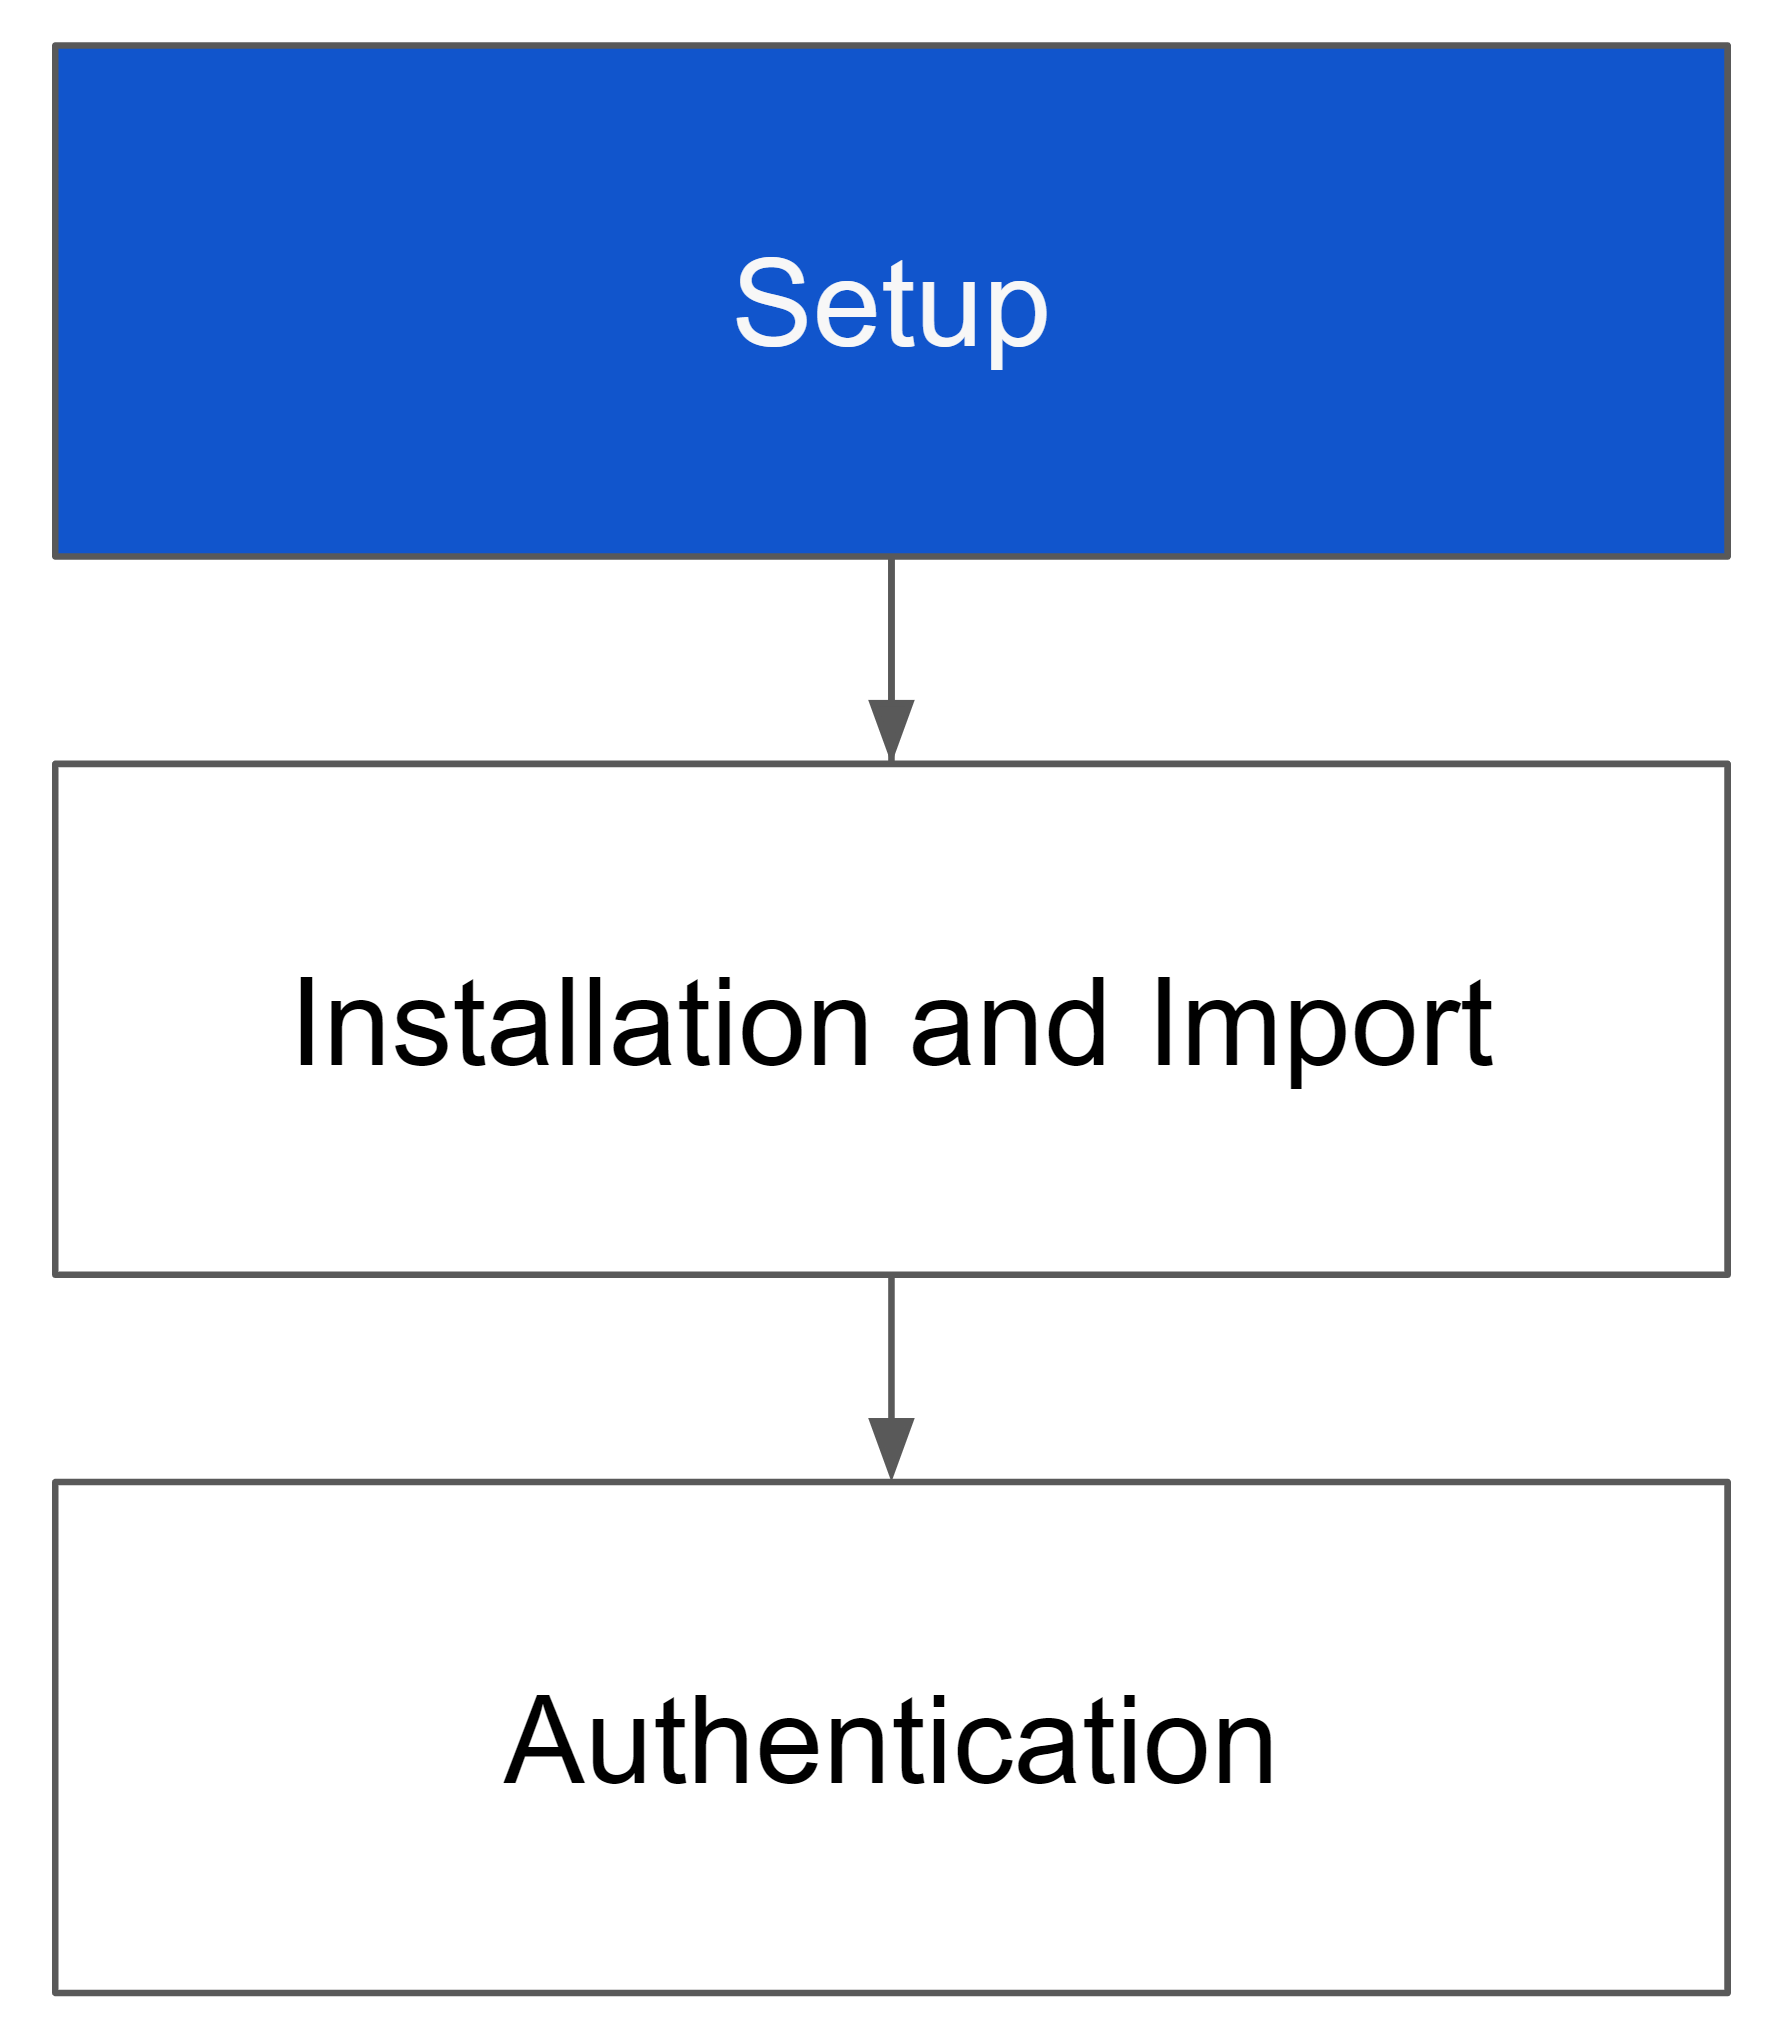</p>
>

###**1.1 Installation and import**

In [1]:
!pip install -q openai==1.2.0 \
                tiktoken==0.6.0 \
                pypdf==4.0.1 \
                langchain==0.1.1 \
                langchain-community==0.0.13 \
                chromadb==0.4.22 \
                sentence-transformers==2.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.9/219.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
import json
import tiktoken

import pandas as pd

from openai import AzureOpenAI

from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_community.embeddings.sentence_transformer import (SentenceTransformerEmbeddings)
from langchain_community.vectorstores import Chroma

# from google.colab import userdata

###**1.2 Authentication**

In [3]:
with open('config.json', 'r') as az_creds:
    data = az_creds.read()

In [4]:
creds = json.loads(data)

In [5]:
client = AzureOpenAI(
    azure_endpoint=creds["AZURE_OPENAI_ENDPOINT"],
    api_key=creds["AZURE_OPENAI_KEY"],
    api_version=creds["AZURE_OPENAI_APIVERSION"]
)

In [6]:
deployment_name = creds["CHATGPT_MODEL"]

## **2. Assemble Vector Database**

###**Steps:**

2.1 Download Data

2.2 Chunking Documents

2.3 Database Creation

<p align="right">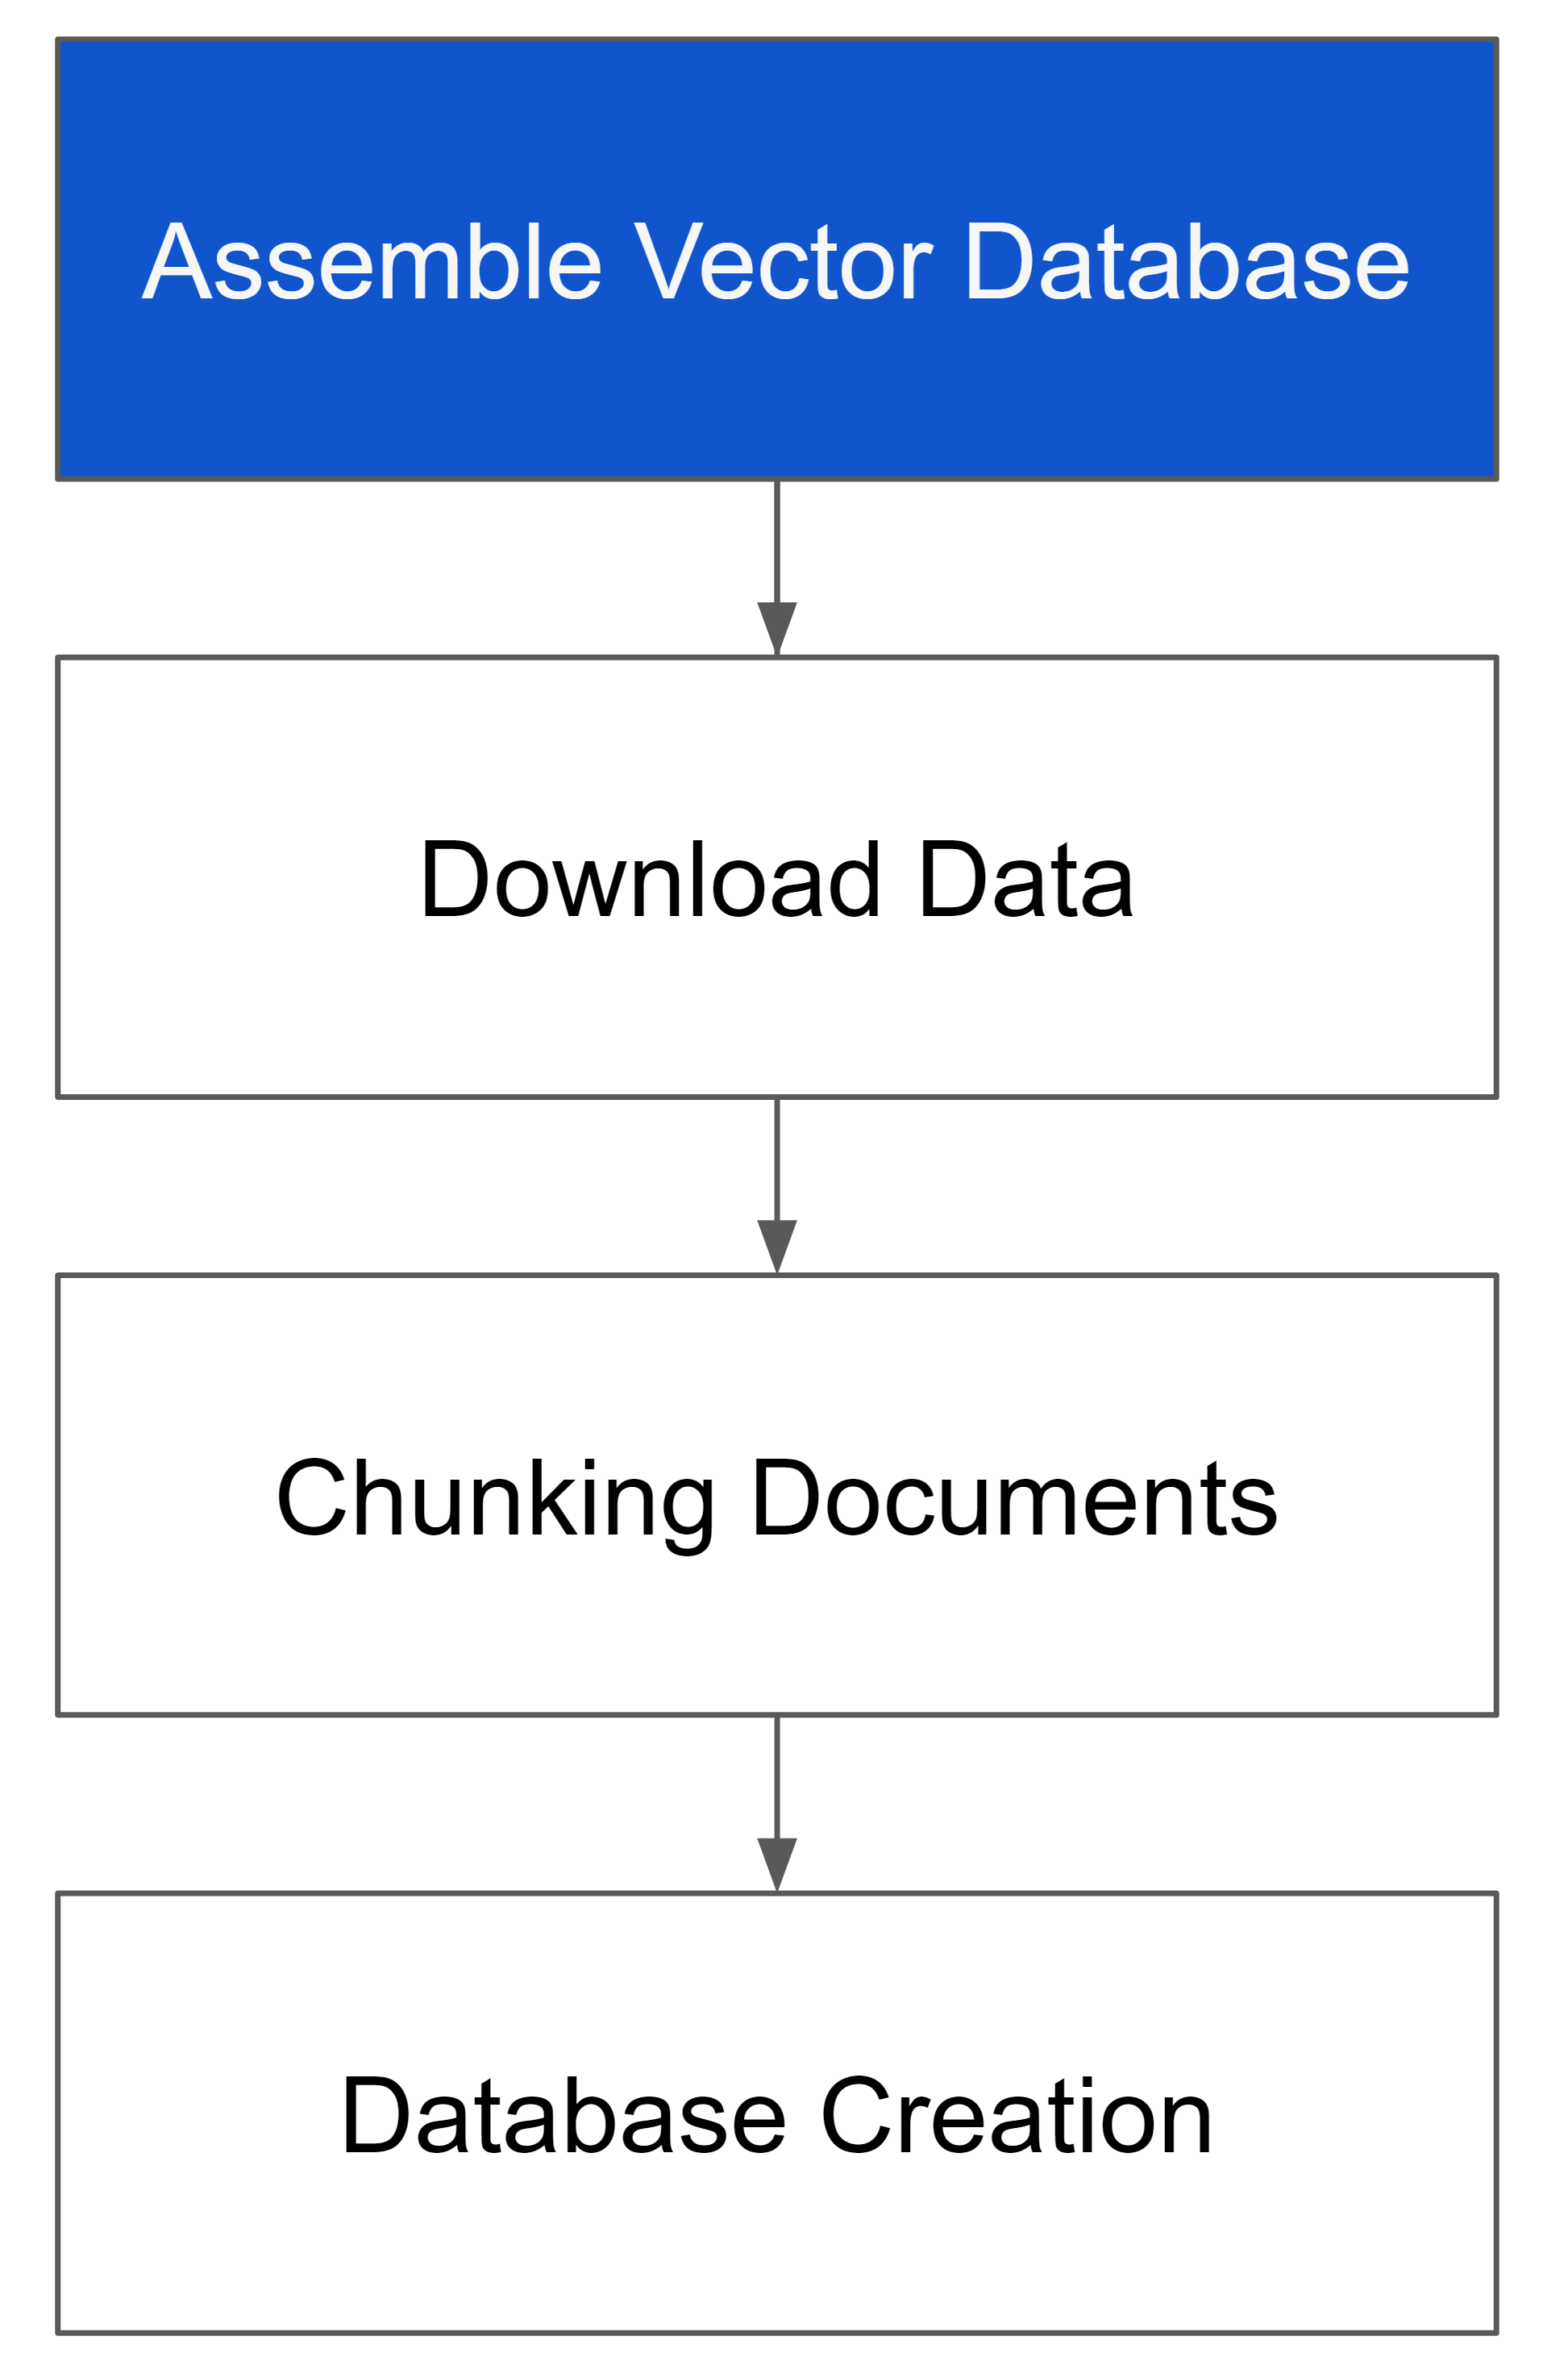</p>

###**2.1 Download Data**

In [7]:
!unzip tesla-annual-reports.zip

Archive:  tesla-annual-reports.zip
   creating: tesla-annual-reports/
  inflating: tesla-annual-reports/tsla-20221231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-20221231-gen.pdf  
  inflating: tesla-annual-reports/tsla-20231231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-20231231-gen.pdf  
  inflating: tesla-annual-reports/tsla-10ka_20211231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-10ka_20211231-gen.pdf  
  inflating: tesla-annual-reports/tsla-10k_20201231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-10k_20201231-gen.pdf  
  inflating: tesla-annual-reports/tsla-10k_20191231-gen_0.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-10k_20191231-gen_0.pdf  


###**2.2 Chunking Documents**

In [8]:
pdf_folder_location = "tesla-annual-reports"

In [9]:
pdf_loader = PyPDFDirectoryLoader(pdf_folder_location)

In [10]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16
)

In [11]:
tesla_10k_chunks_ada = pdf_loader.load_and_split(text_splitter)
# Takes 5-6 minutes to run

In [12]:
len(tesla_10k_chunks_ada)

3342

###**2.3 Database Creation**

In [13]:
tesla_10k_collection = 'tesla-10k-2019-to-2023'

In [15]:
embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [18]:
# Takes 5-10 minutes to run
vectorstore = Chroma.from_documents(
    tesla_10k_chunks_ada,
    embedding_model,
    collection_name=tesla_10k_collection,
    persist_directory='./tesla_db'
)

In [21]:
vectorstore.persist()

In [22]:
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    persist_directory='./tesla_db',
    embedding_function=embedding_model
)

In [23]:
retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

In [24]:
!zip -r tesla_db.zip /content/tesla_db

  adding: content/tesla_db/ (stored 0%)
  adding: content/tesla_db/3ae5289a-894a-4486-8b67-a30be1b99713/ (stored 0%)
  adding: content/tesla_db/3ae5289a-894a-4486-8b67-a30be1b99713/header.bin (deflated 55%)
  adding: content/tesla_db/3ae5289a-894a-4486-8b67-a30be1b99713/link_lists.bin (deflated 81%)
  adding: content/tesla_db/3ae5289a-894a-4486-8b67-a30be1b99713/length.bin (deflated 79%)
  adding: content/tesla_db/3ae5289a-894a-4486-8b67-a30be1b99713/data_level0.bin (deflated 9%)
  adding: content/tesla_db/3ae5289a-894a-4486-8b67-a30be1b99713/index_metadata.pickle (deflated 76%)
  adding: content/tesla_db/chroma.sqlite3 (deflated 44%)


## **3. Querying the Vector Database**

###**Steps:**

3.1 Load Vector Database

3.2 Prompt Design

3.3 Retrieving relevant documents

3.4 Compose Response

<p align="right">
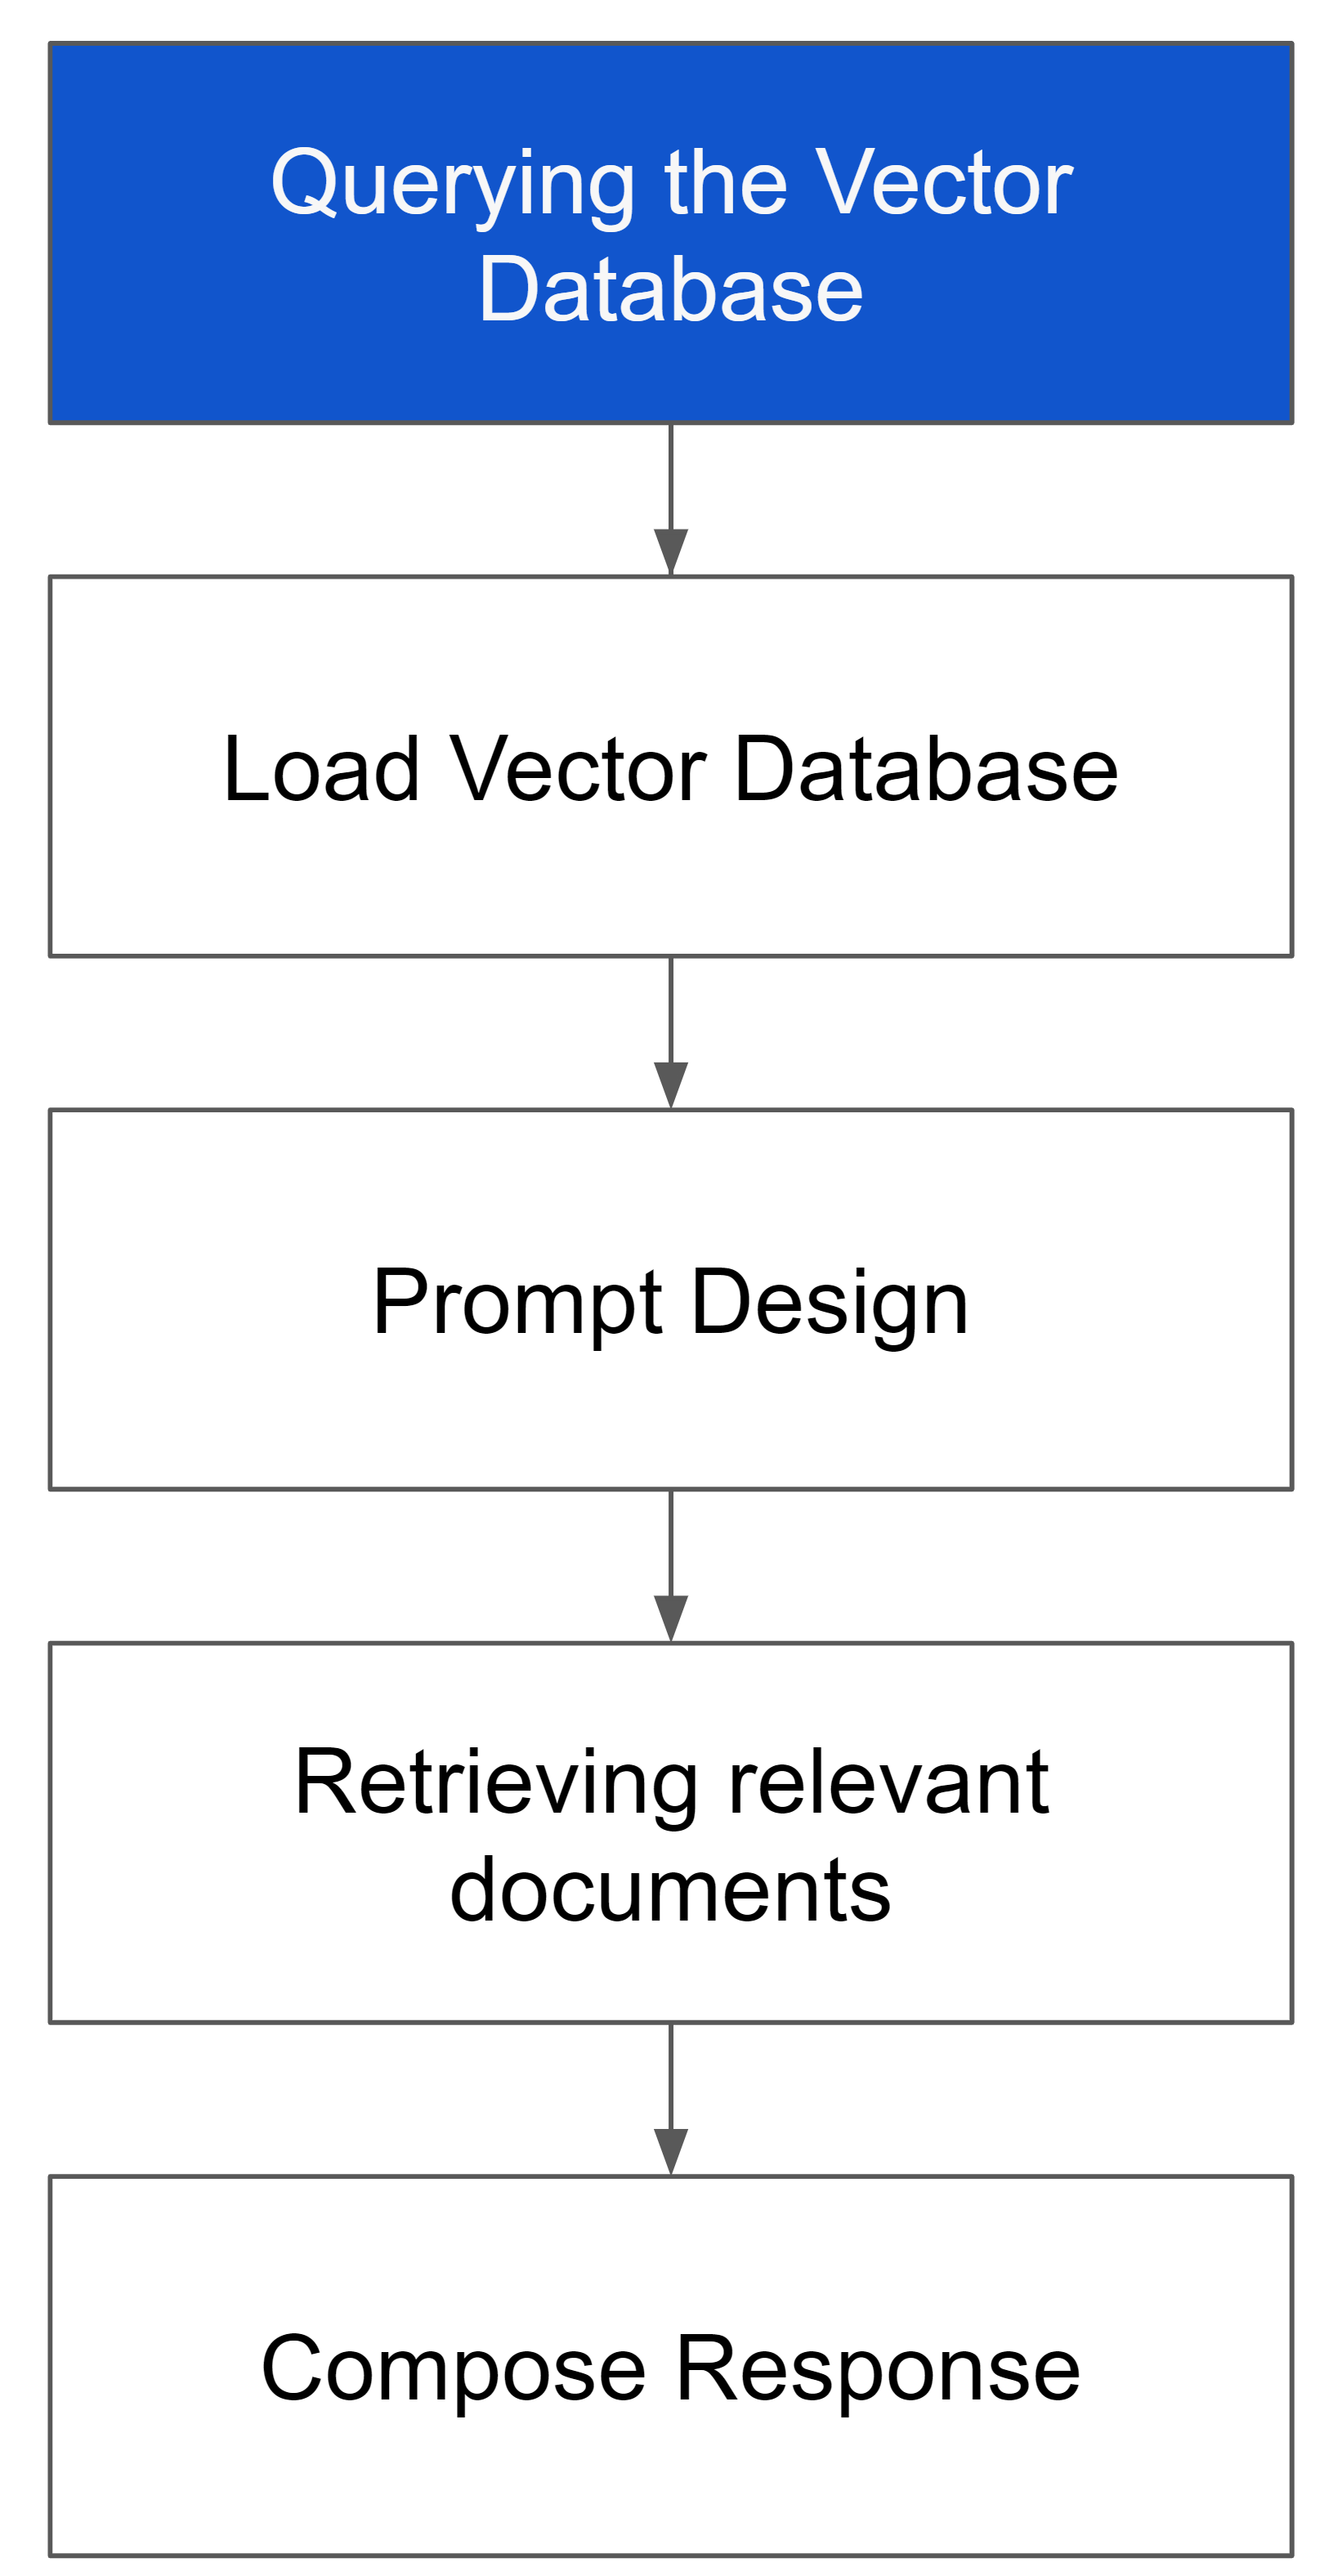<p>

###**3.1 Load Vector Database**

In [25]:
embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [26]:
!gdown 1hWbAWhJr5xsl0sAvvEq9Wpo8ItCdZpdq

Downloading...
From (original): https://drive.google.com/uc?id=1hWbAWhJr5xsl0sAvvEq9Wpo8ItCdZpdq
From (redirected): https://drive.google.com/uc?id=1hWbAWhJr5xsl0sAvvEq9Wpo8ItCdZpdq&confirm=t&uuid=772df538-9bd0-482f-b925-7cfbae6b6be5
To: /content/tesla_db.zip
100% 36.5M/36.5M [00:00<00:00, 84.6MB/s]


In [27]:
!unzip tesla_db.zip

Archive:  tesla_db.zip
   creating: content/tesla_db/
   creating: content/tesla_db/8ac3fef6-b222-4e92-a75c-b38882ef1f45/
  inflating: content/tesla_db/8ac3fef6-b222-4e92-a75c-b38882ef1f45/header.bin  
  inflating: content/tesla_db/8ac3fef6-b222-4e92-a75c-b38882ef1f45/link_lists.bin  
  inflating: content/tesla_db/8ac3fef6-b222-4e92-a75c-b38882ef1f45/length.bin  
  inflating: content/tesla_db/8ac3fef6-b222-4e92-a75c-b38882ef1f45/data_level0.bin  
  inflating: content/tesla_db/8ac3fef6-b222-4e92-a75c-b38882ef1f45/index_metadata.pickle  
  inflating: content/tesla_db/chroma.sqlite3  


In [28]:
tesla_10k_collection = 'tesla-10k-2019-to-2023'

In [29]:
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    persist_directory='./content/tesla_db',
    embedding_function=embedding_model
)

In [30]:
retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

###**3.2 Prompt Design**

In [31]:
qna_system_message = """
You are an assistant to a financial services firm who answers user queries on annual reports.
User input will have the context required by you to answer user questions.
This context will begin with the token: ###Context.
The context contains references to specific portions of a document relevant to the user query.

User questions will begin with the token: ###Question.

Please answer user questions only using the context provided in the input.
Do not mention anything about the context in your final answer. Your response should only contain the answer to the question.

If the answer is not found in the context, respond "I don't know".
"""

In [32]:
qna_user_message_template = """
###Context
Here are some documents that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

###**3.3 Retrieving relevant documents**

In [33]:
user_input = "What was the annual revenue of the company in 2022?"

In [34]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)

In [35]:
len(relevant_document_chunks)

5

In [36]:
for document in relevant_document_chunks:
    print(document.page_content.replace("\t", " "))
    break

systems.
In 2020, we recognized total revenues of $31.54 billion, representing an increase of $6.96 billion compared to the prior year. We continue to ramp
production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue
growth.
In 2020, our net income attributable to common stockholders was $721 million, representing a favorable change of $1.58 billion compared to the prior
year. In 2020, our operating margin was 6.3%, representing a favorable change of 6.6% compared to the prior year. We continue to focus on operational
efficiencies, while we have seen an acceleration of non-cash stock-based compensation expense due to a rapid increase in our market capitalization and updates
to our business outlook.
We ended 2020 with $19.38 billion in cash and cash equivalents, representing an increase of $13.12 billion from the end of 2019. Our cash flows from
operating activities during 2020 was $5.94 billion

###**3.4 Composing response**

In [37]:
user_input = "What was the annual revenue of the company in 2022?"

In [38]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)

prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_input
        )
    }
]

try:
    response = client.chat.completions.create(
        model=deployment_name,
        messages=prompt,
        temperature=0
    )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
    prediction = f'Sorry, I encountered the following error: \n {e}'

print(prediction)

The annual revenue of the company in 2022 is $81.462 billion.


## **4. Evaluate Results**

###**Steps:**

4.1 Setup LLM as a Judge

4.2 Evaluate

<p align="right">
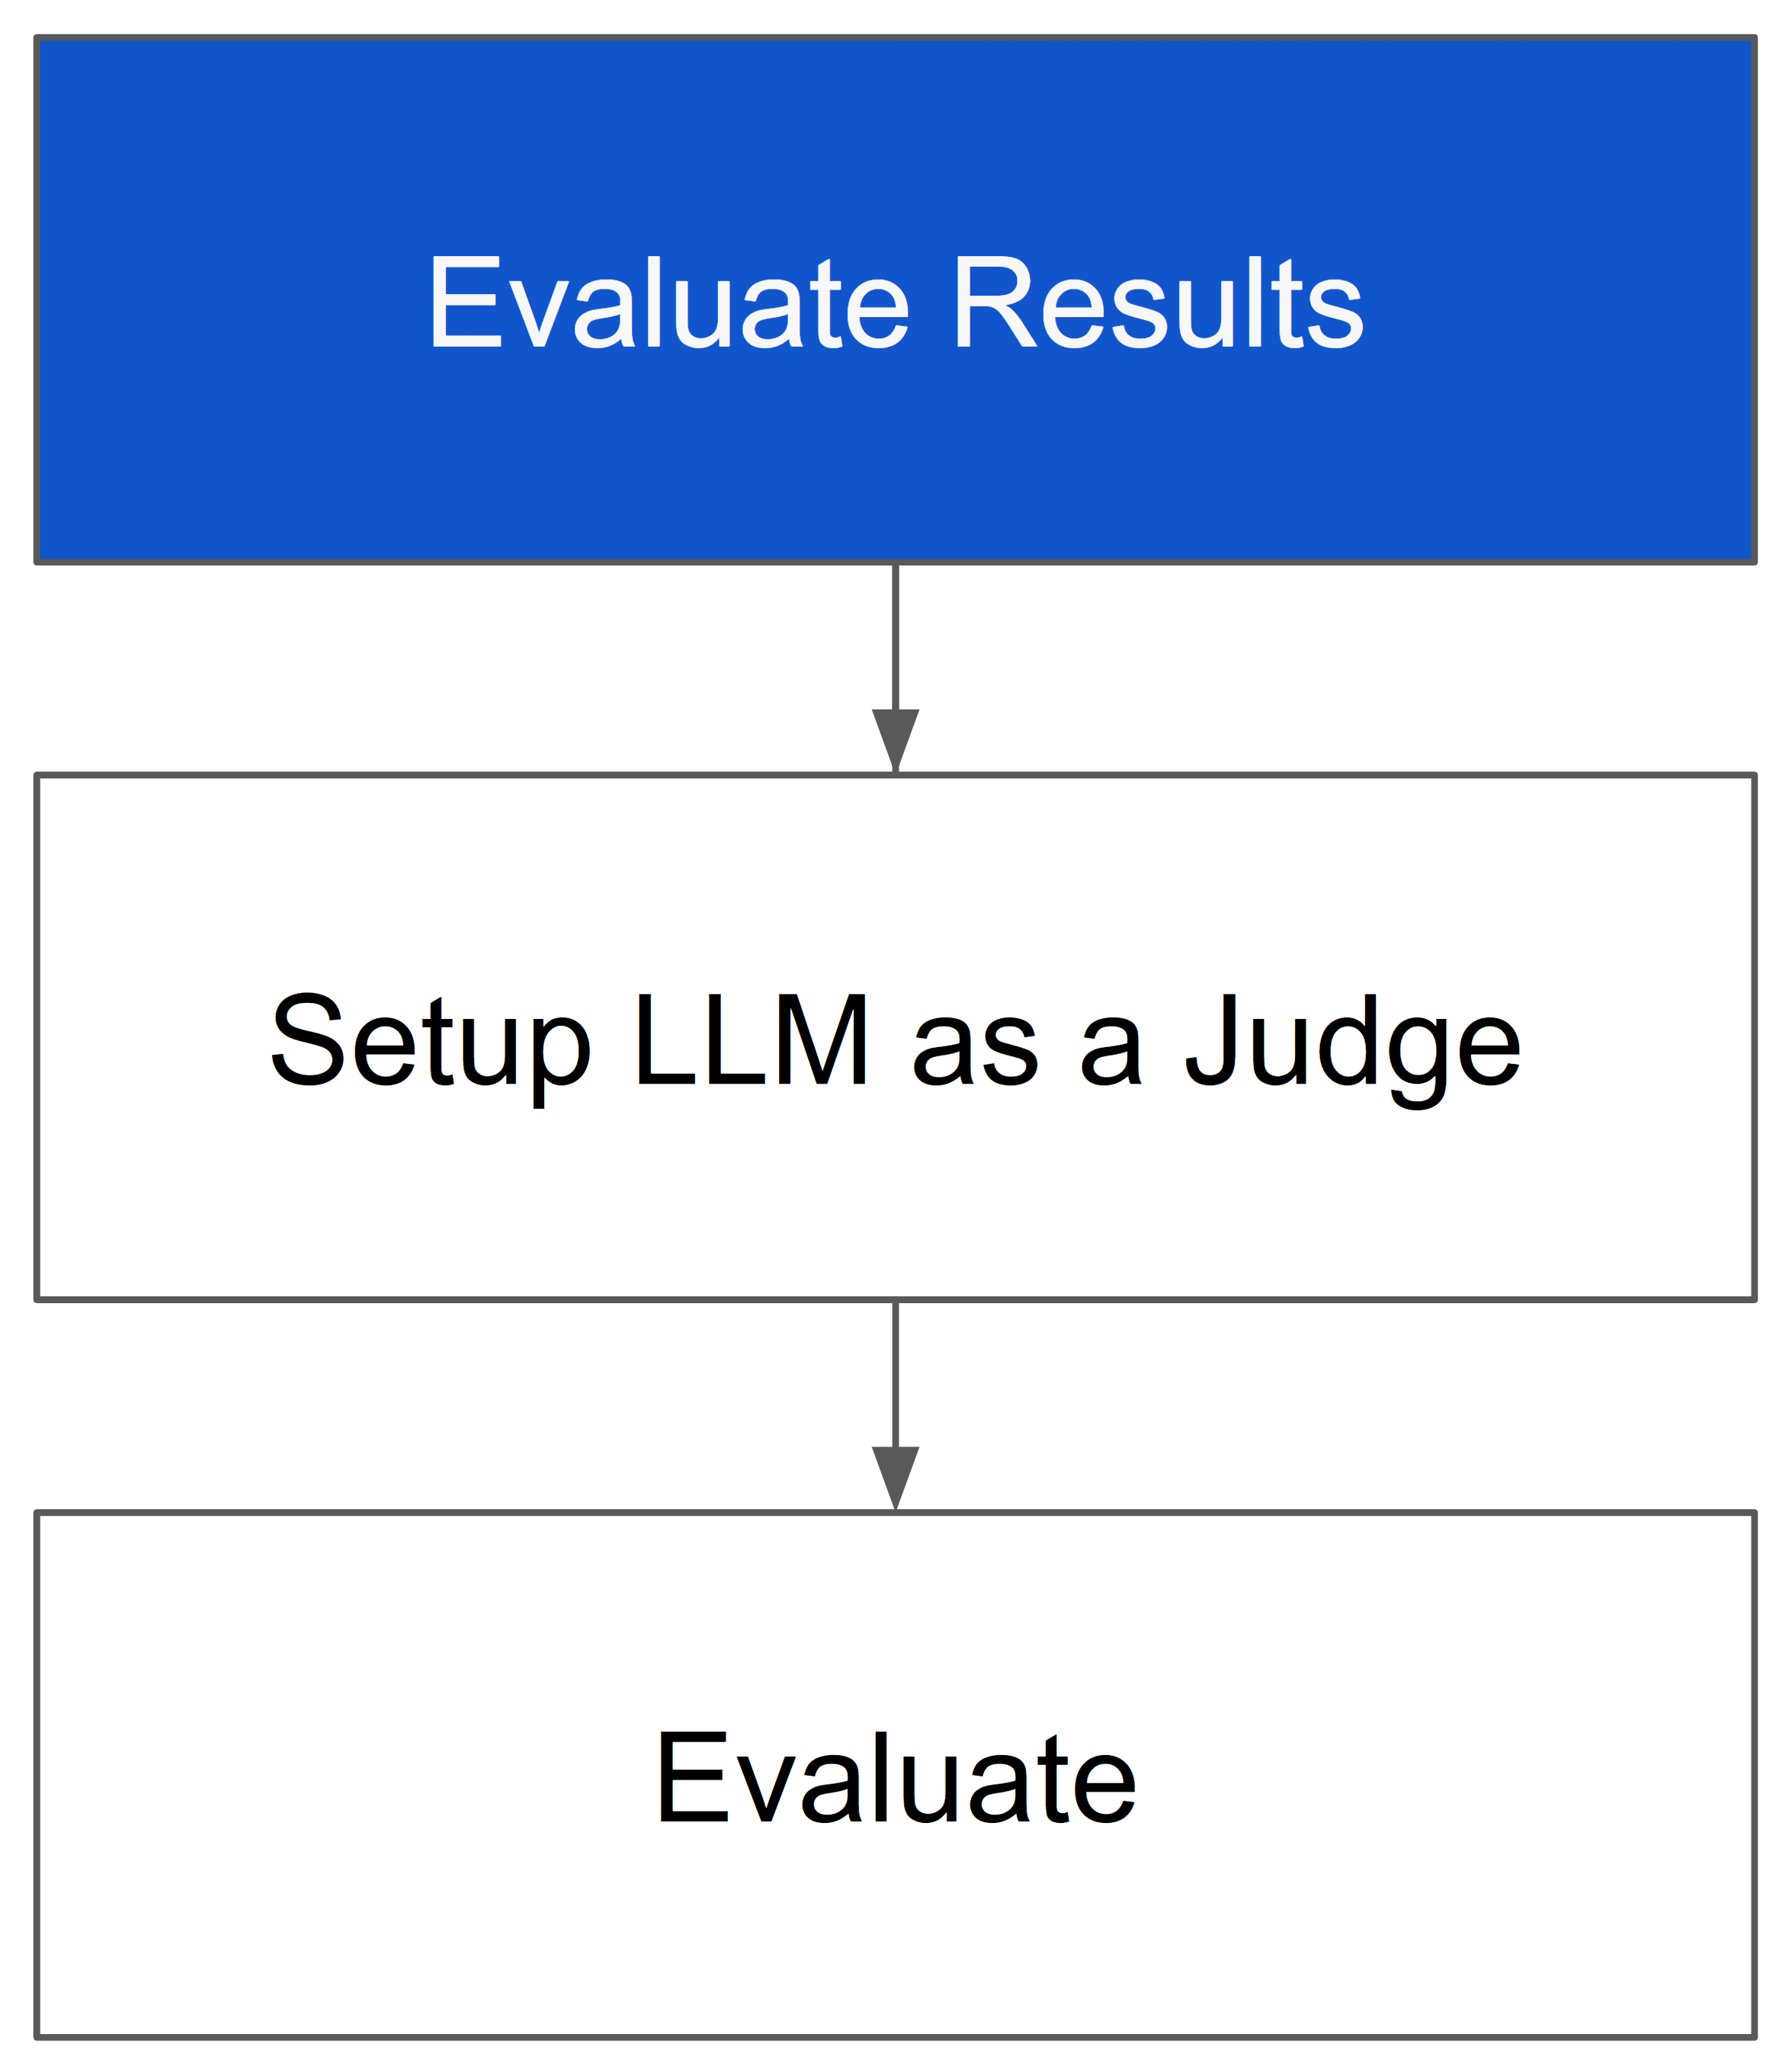
</p>

###**4.1 Setup LLM as a Judge**

In [39]:
rater_model = deployment_name # 'gpt-35-turbo'

In [40]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context.

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.
"""

In [41]:
relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score.
"""

In [42]:
groundedness_user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

In [43]:
relevance_user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

###**4.2 Evaluate**

In [46]:
answer=prediction

In [47]:
groundedness_prompt = [
    {'role':'system', 'content': groundedness_rater_system_message},
    {'role': 'user', 'content': groundedness_user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [48]:
response = client.chat.completions.create(
    model=rater_model,
    messages=groundedness_prompt,
    temperature=0
)

print(response.choices[0].message.content)

Evaluation Steps:
1. Identify the question asked.
2. Check if the answer provided is relevant to the question asked.
3. Check if the answer is derived only from the information presented in the context.

Explanation:
1. The question asked is "What was the annual revenue of the company in 2022?"
2. The answer provided is relevant to the question asked as it directly provides the annual revenue of the company in 2022.
3. The answer is derived only from the information presented in the context as it directly quotes the revenue figures presented in the table for the year 2022.

Extent to which the metric is followed: 5 - The metric is followed completely.

Therefore, the answer is rated 5 according to the evaluation criteria.


In [51]:
relevance_prompt = [
    {'role':'system', 'content': relevance_rater_system_message},
    {'role': 'user', 'content': relevance_user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [52]:
response = client.chat.completions.create(
    model=rater_model,
    messages=relevance_prompt,
    temperature=0
)

print(response.choices[0].message.content)

To evaluate the context as per the metric, we need to check whether the answer addresses the main aspects of the question, i.e., the annual revenue of the company in 2022, based on the context provided. We need to ensure that all and only the important aspects are contained in the answer.

The context provides a detailed breakdown of the company's revenues and profits for the years 2020, 2021, and 2022. It also provides a table that presents revenues by geographic area based on the sales location of the company's products. Based on the context, we can see that the answer provided is relevant to the question as it directly addresses the main aspect of the question, i.e., the annual revenue of the company in 2022. The answer is also supported by the information provided in the context.

Therefore, the metric is followed completely, and the context adheres to the metric.

Based on the evaluation criteria, we can assign a score of 5 to the context as it follows the metric completely.
